# Summary of the Model

Here I provide a summary of what I include in the model. In the next section, detailed explaination on the procedure is provided.

First of all, I get block group codes from census API (since they are missing in the current dataset). Since location is arguably the most important factor in real estate price, getting as much detail on location as possible is the first order of business.

Since block group level data is not available for all blocks, I impute the missing ones using the average of other observations that are located withing a certain distance of the said house.

Having the block group codes, I will add some public information* about the blocks to the data as well. The most important features I get from public domain is:

* neighborhood level crime rate
* number of people living in poverty in neighborhood
* school district graduation rate
* number of workers whose workplace is in the neighborhood
* number of workers whose residence is in the neighborhood

all of which are cruical factors in housing price as explored in the real estate literature.

Another important factor is the distance from central business district which I add to the feature vector. This is theoretically one of the most important factor in real estate evaluation and explains a lot of variation.

I also add quadratic terms for some variables that seem to have nonlinear relationship with price.

Another important transformation is that I train the model for prediction of log prices instead of prices themselves. Since price usually has a logarithmic behaviour, predicting log prices and transforming them back to levels gives a better prediction.

I have 3 models to compare at the end:

* linear regression
* gradient boosting
* random forest

I compare the result of the three and pick the best one. The validation is done on 20% of the train data and the training is done on the remaining 80%.

The main packages I use for my analysis are the following:

* sklearn
* pandas
* numpy

I also use some commands from the following packages in my code:

* geopandas
* requests
* seaborn
* matplotlib
* haversine

Going forward, there are several strategies I would pursue if I had more time:
<ol>
    <li>Getting as much information as possible on various aspects of neighborhood quality since those are very good predictors of price. Specifically, here I used just the static measures, but including data about the trends in any of those variables are also helpful, since trends shape expectations and expectations shape prices.</li>
    <li>Coming up with a better way to transform categorical variables associated with location (like block codes or school districts). I can't stress this enough that location is everything! The better one can come up with a way to make various blocks into different cardinal heirarchies, the better the predictions can become. I actually think that this very problem is the main factor when it comes to creating a good prediction for housing prices.</li>   
    <li>Exploring the nonlinearity of relationships further. Here I just included a quadratic term in a linear model, but a better way would be to completely go nonlinear by using at least some layers of neural network and stacking several models together. Stacking here can really do wonders if done with more rigor and with a longer time frame at hand.</li>
</ol>

\* For this model, I used some public datasets that I download and save on my hard drive. I don't include them in the folder I email to you but I can provide them on demand.

The detailed explaination on the process of cleaning the data, feature selection and model training and validation is provided below:

# Initialization

In [1]:
#!pip install haversine
#!pip install geopandas

In [2]:
import pandas as pd
import os
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import BallTree
from sklearn.metrics import make_scorer
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import geopandas
import haversine as hs


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [3]:
def AAPError(Y_actual, Y_Predicted):
    aape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return aape

In [4]:

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    All args must be of equal length.    
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [5]:
data = pd.read_csv(os.getcwd()+'/Data Science ZExercise_TRAINING_CONFIDENTIAL1.csv')

# Cleaning and Transformation

First of all we examine the data for the presence of missing values:

In [6]:
pd.set_option('display.max_rows', 40)
data.isnull().sum(axis=0).reset_index(name='count')

index  count
0           PropertyID      0
1        SaleDollarCnt      0
2            TransDate      0
3     censusblockgroup      0
4       ZoneCodeCounty      0
5              Usecode      0
6           BedroomCnt      0
7          BathroomCnt      0
8   FinishedSquareFeet      0
9     GarageSquareFeet   2841
10   LotSizeSquareFeet      0
11            StoryCnt      0
12           BuiltYear      0
13            ViewType   8956
14            Latitude      0
15           Longitude      0
16      BGMedHomeValue      6
17           BGMedRent   2631
18      BGMedYearBuilt    247
19            BGPctOwn      0
20         BGPctVacant      0
21         BGMedIncome      0
22           BGPctKids      0
23            BGMedAge      0

To get some visual idea about distributions and dependencies in the data, let's plot pairwise scatter plots and distributions:

In [7]:
data.describe()

PropertyID  SaleDollarCnt  censusblockgroup  Usecode    BedroomCnt  \
count  1.158800e+04   1.158800e+04      1.158800e+04  11588.0  11588.000000   
mean   5.502866e+07   6.137157e+05      5.300000e+11      9.0      3.451800   
std    1.605832e+07   4.577593e+05      0.000000e+00      0.0      0.865682   
min    4.864894e+07   2.000000e+04      5.300000e+11      9.0      1.000000   
25%    4.880374e+07   3.550000e+05      5.300000e+11      9.0      3.000000   
50%    4.895489e+07   5.050000e+05      5.300000e+11      9.0      3.000000   
75%    4.910697e+07   7.150000e+05      5.300000e+11      9.0      4.000000   
max    1.244354e+08   7.880000e+06      5.300000e+11      9.0      9.000000   

        BathroomCnt  FinishedSquareFeet  GarageSquareFeet  LotSizeSquareFeet  \
count  11588.000000        11588.000000       8747.000000       1.158800e+04   
mean       2.327628         2199.899249        490.981022       1.601437e+04   
std        0.872601          936.877939        220.434500       4.324446e+04   
min        0.750000          270.000000         10.000000       1.034000e+03   
25%        1.750000         1530.000000        380.000000       5.683750e+03   
50%        2.500000         2060.000000        476.000000       7.886500e+03   
75%        3.000000         2700.000000        600.000000       1.111100e+04   
max        9.500000        12130.000000       7504.000000       1.157824e+06   

           StoryCnt     BuiltYear     ViewType      Latitude     Longitude  \
count  11588.000000  11588.000000  2632.000000  1.158800e+04  1.158800e+04   
mean       1.528571   1975.423097    97.994301  4.755070e+07 -1.221995e+08   
std        0.521864     28.053849    52.484480  1.424218e+05  1.417068e+05   
min        1.000000   1900.000000    78.000000  4.716120e+07 -1.225150e+08   
25%        1.000000   1957.000000    78.000000  4.744830e+07 -1.223147e+08   
50%        2.000000   1979.000000    79.000000  4.756348e+07 -1.222056e+08   
75%        2.000000   1999.000000    82.000000  4.767496e+07 -1.221112e+08   
max        3.000000   2015.000000   247.000000  4.785848e+07 -1.211670e+08   

       BGMedHomeValue    BGMedRent  BGMedYearBuilt      BGPctOwn  \
count    1.158200e+04  8957.000000    11341.000000  11588.000000   
mean     4.337194e+05  1235.541699     1973.356406      0.747764   
std      1.781283e+05   394.371247       17.786514      0.196277   
min      1.480000e+04   185.000000     1939.000000      0.000000   
25%      3.020000e+05   933.000000     1960.000000      0.618700   
50%      3.969000e+05  1173.000000     1975.000000      0.802200   
75%      5.256000e+05  1508.000000     1987.000000      0.903800   
max      1.000001e+06  2001.000000     2005.000000      1.000000   

        BGPctVacant    BGMedIncome     BGPctKids      BGMedAge  
count  11588.000000   11588.000000  11588.000000  11588.000000  
mean       0.050873   94859.222817      0.360058     39.772886  
std        0.058676   36285.661949      0.140494      6.726432  
min        0.000000   17500.000000      0.000000     18.200000  
25%        0.000000   69167.000000      0.260700     35.000000  
50%        0.038900   90455.000000      0.352600     39.400000  
75%        0.080800  114306.000000      0.444200     43.800000  
max        0.638400  250001.000000      0.934100     70.200000

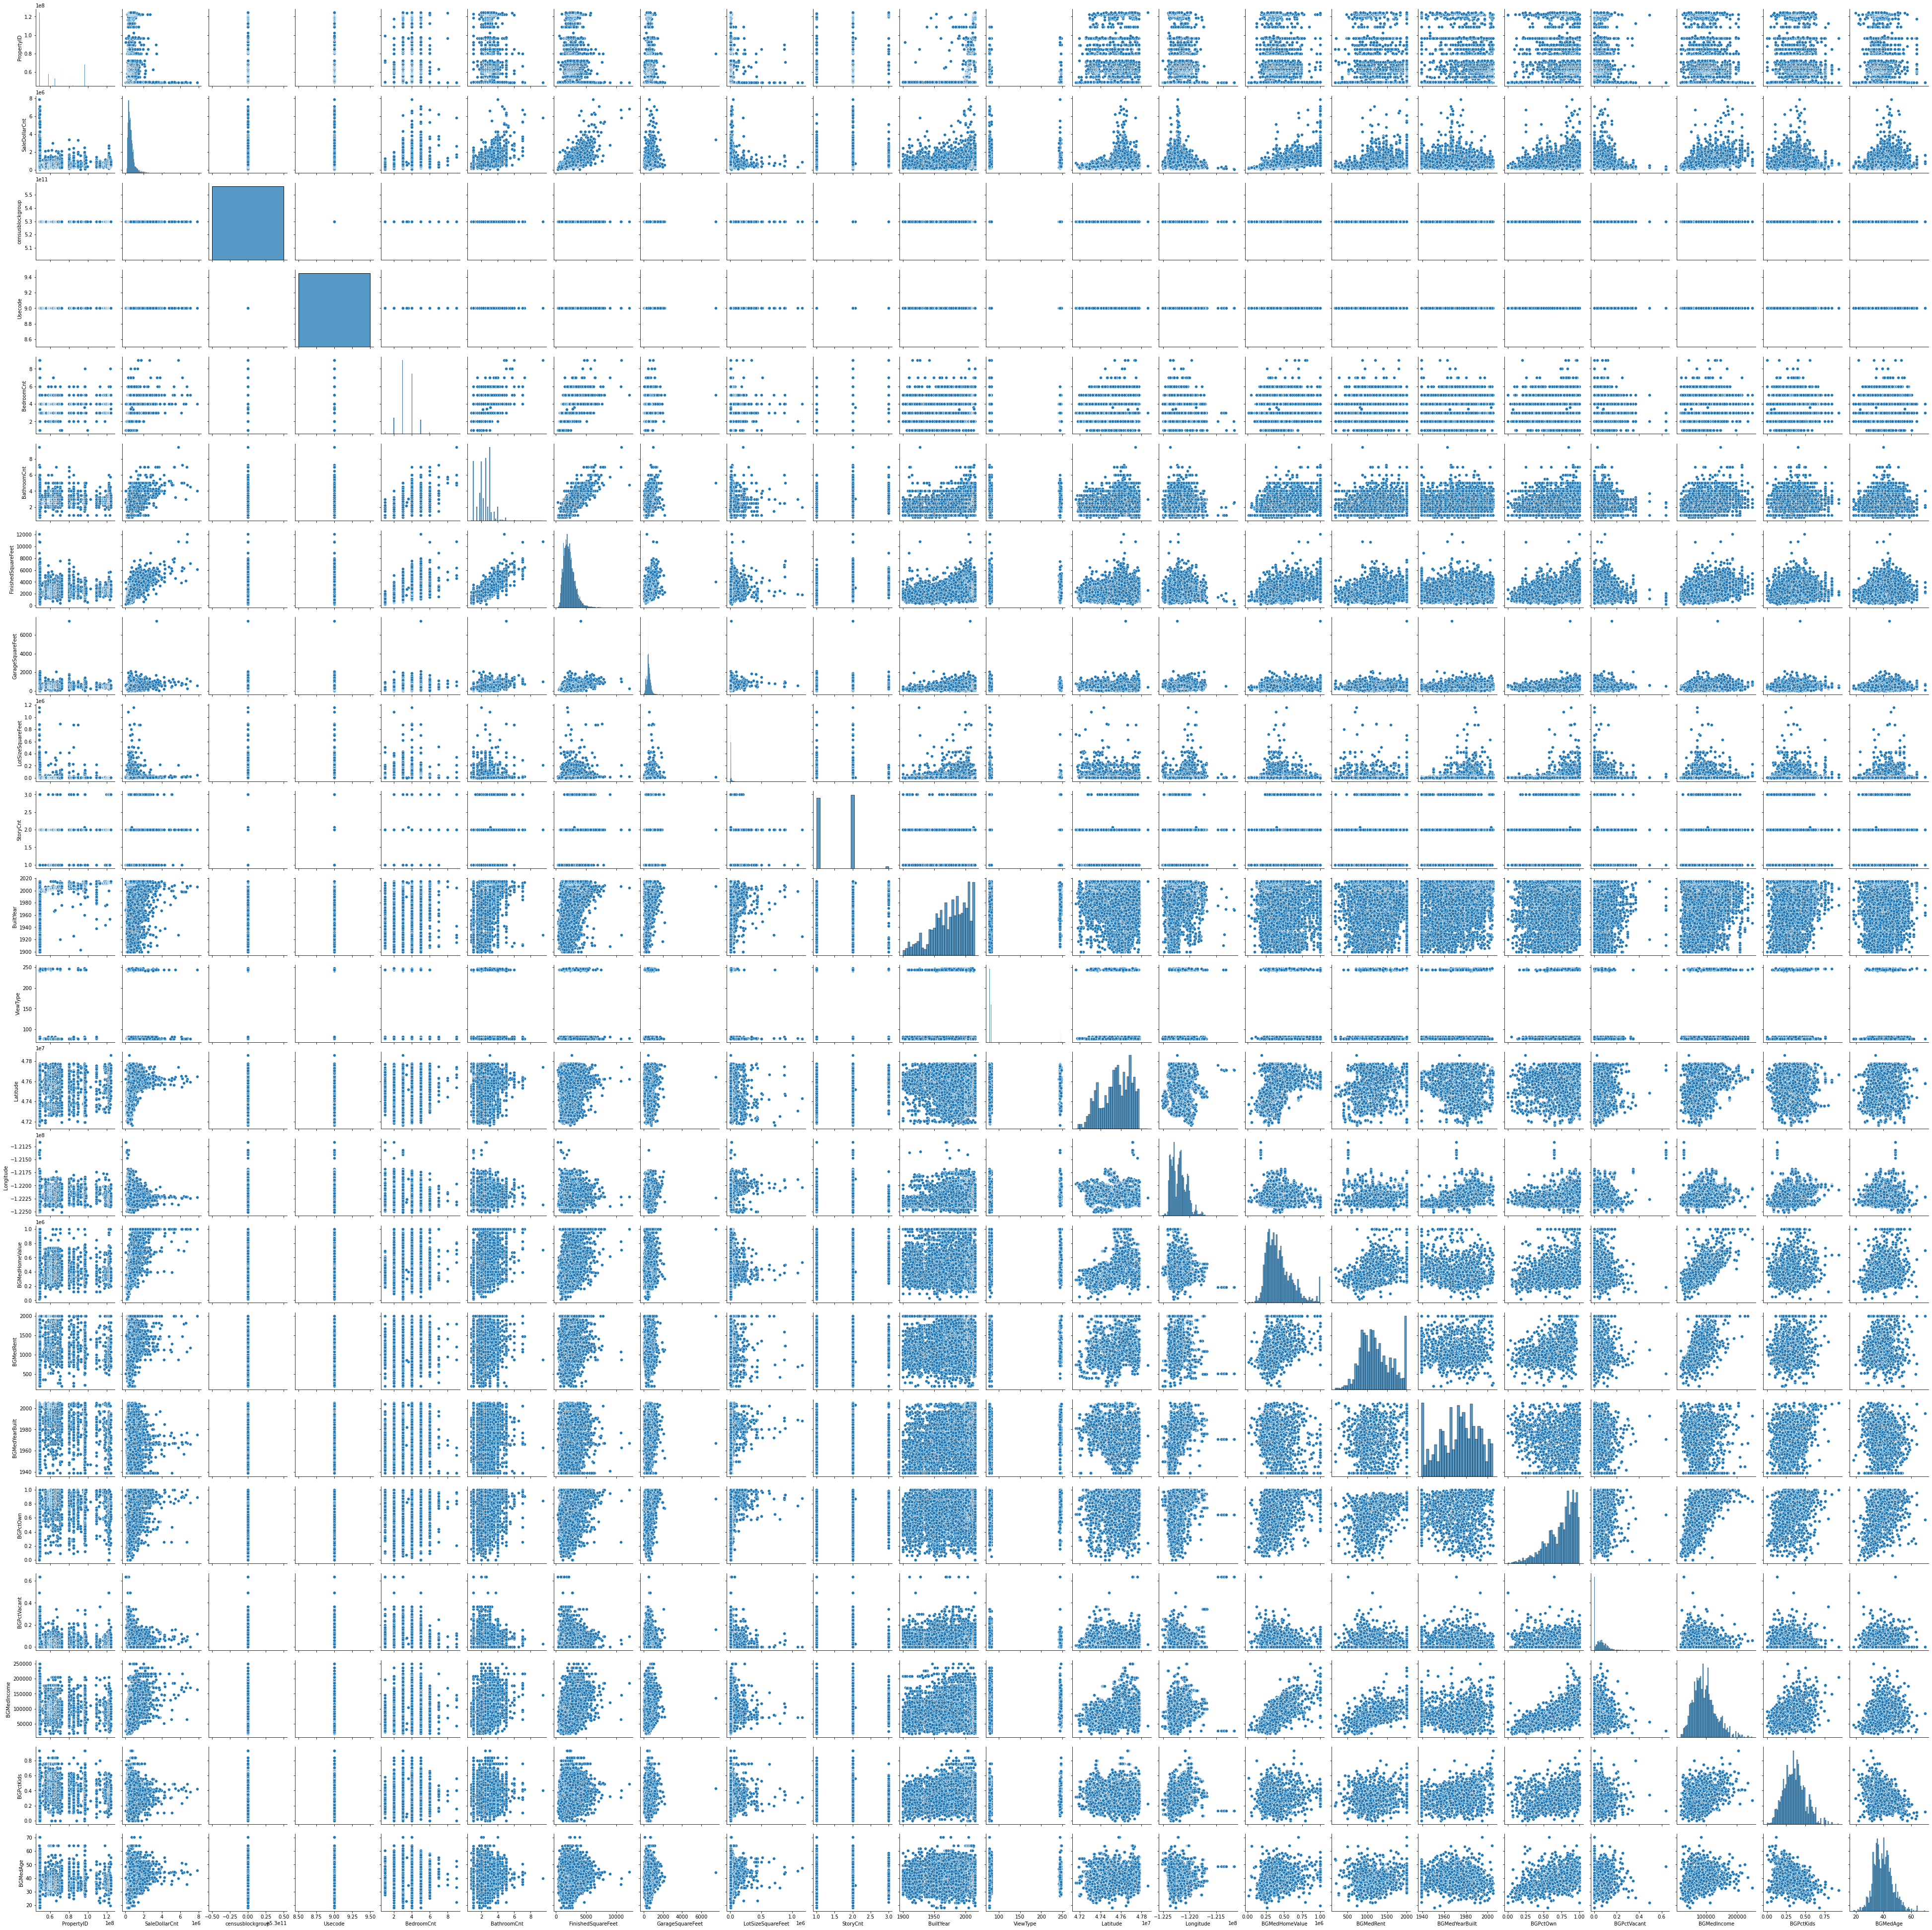

In [8]:
sns.pairplot(data)

After some examinations, it is clear that some variables need fixing. It is straightforward to fix the missing observations for some variables. For example, StoryCnt variable only supposed to take integer values. I replace the few non-integer ones to the nearest integer. Same thig goes for BuiltYear as it has non-integer values too.

Missing in terms of GarageSquareFeet probably means that the property doesn't have a garage. so we can replace missing here with zero. 

Missing in terms of ViewType also means that the property doesn't have a view. I replace it with zero as well ( it is a categorical variable so the value doesn't really matter as long as it is a new value and not already one of the values that this variable takes).

Also I drop Usecode since it takes the same value for all observations and is redundant.

In [9]:
#feature transformation
data.drop(columns=['Usecode'])
data['StoryCnt'] = np.floor(data['StoryCnt']).astype(int).astype(str)
data['BuiltYear'] = np.ceil(data['BuiltYear'])

data['ViewType'].fillna(0, inplace=True)
data['ViewType'] = data['ViewType'].astype(int).astype(str)

data['GarageSquareFeet'].fillna(0, inplace=True)
data['TransYear'] = pd.DatetimeIndex(data['TransDate']).year
data['TransMonth'] = pd.DatetimeIndex(data['TransDate']).month
data['TransDay'] = pd.DatetimeIndex(data['TransDate']).day

For block group median variables (BGMedHomeValue,BGMedRent,BGMedYearBuilt) I have to come up with a value based on the average in the block group. But there is a catch here. I notice that the census block group information is recorded incorrectly. It takes only one variable across all observations, which is not what it supposed to look like. 

In [10]:
len(data['censusblockgroup'].unique())

1

I can just get the block code by reverse geocoding using US Census geocoding API. This is slow and needs and API key (takes about half an hour for this data) but gives reliable information. 

In [12]:
#get block groups from census
def geolocate(lat,lon):
    url ="https://geo.fcc.gov/api/census/area?lat="+str(lat)+"&lon="+str(lon)+"&format=json&key=dbc2d7c853685d819112b8a9da3f72c8a61cdbf1" 
    return requests.get(url).json()['results'][0]['block_fips']

#only run this once and save
flag = 1
if flag==0:
#geolocate all
    data['Block']=np.nan
    for i in data.index:
        data.at[i,'Block'] = geolocate(data.loc[i,'map_Latitude'],data.loc[i,'map_Longitude'])

    data['BlockGroup'] = np.floor(data['Block']/1000).astype(int)
    data.to_csv(os.getcwd()+'/data_BG_added.csv')


I add crime information, downloaded from Seattle Police Department website. It only contains the number of crime in each block over a decade which is just a crude measure to score block groups based on crime rates:

In [13]:
data = pd.read_csv(os.getcwd()+'/data_BG_added.csv')
crime_data = pd.read_csv(os.getcwd()+'/crime_BG.csv')
data = pd.merge(data, crime_data, how="left", on=["BlockGroup"])
data['crime_count'] = data['crime_count'].fillna(0)

Next, I incorporate Census LEHD LODES data on worker and resident counts in each block. This adds some information about the nature of blocks which will help the prediction:

In [14]:
rac = pd.read_csv(os.getcwd()+'/wa_rac_S000_JT00_2015.csv')[['BlockGroup','r_C000']]
wac = pd.read_csv(os.getcwd()+'/wa_wac_S000_JT00_2015.csv')[['BlockGroup','w_C000']]
data = pd.merge(data, rac, how="left", on=["BlockGroup"])
data['r_C000'] = data['r_C000'].fillna(0)
data = pd.merge(data, wac, how="left", on=["BlockGroup"])
data['w_C000'] = data['w_C000'].fillna(0)

I also add information about school districts ranking to the model which has shown to be very important in property price determination:

In [15]:
school = pd.read_csv(os.getcwd()+'/school.csv')
school = school[['BlockGroup','GraduationRate']]
data = pd.merge(data, school, how="left", on=["BlockGroup"])
data['GraduationRate'] = data['GraduationRate'].fillna(0.7)

Last but not least, I include ACS census 2011-2015 information on poverty and income and median housing value at the block group level. Variable descriptions are as following:
    Estimates
    
    Table 1:     Ratio of Income to Poverty Level in the Past 12 Months
    Universe:    Population for whom poverty status is determined
    Source code: C17002
    NHGIS code:  ADNE
        ADNEE001:    Total
        ADNEE002:    Under .50
        ADNEE003:    .50 to .99
        ADNEE004:    1.00 to 1.24
        ADNEE005:    1.25 to 1.49
        ADNEE006:    1.50 to 1.84
        ADNEE007:    1.85 to 1.99
        ADNEE008:    2.00 and over
 
    Table 2:     Housing Units
    Universe:    Housing units
    Source code: B25001
    NHGIS code:  ADPY
        ADPYE001:    Total
 
    Table 3:     Median Gross Rent (Dollars)
    Universe:    Renter-occupied housing units paying cash rent
    Source code: B25064
    NHGIS code:  ADRK
        ADRKE001:    Median gross rent
 
    Table 4:     Median Value (Dollars)
    Universe:    Owner-occupied housing units
    Source code: B25077
    NHGIS code:  ADRW
        ADRWE001:    Median value (dollars)
 

In [16]:
census = pd.read_csv(os.getcwd()+'/census.csv')
data = pd.merge(data, census, how="left", on=["BlockGroup"])

Note that latitude and longitude variable should be converted to the standard unit, which means divided by 10^6

In [17]:
data['map_Latitude'] = data['Latitude']/1000000
data['map_Longitude'] = data['Longitude']/1000000

gdf = geopandas.GeoDataFrame(data,
        geometry=geopandas.points_from_xy(data.map_Longitude, data.map_Latitude))

Neighborhood level variables are not available for some block groups. I infer those missing block group variables as follows: For every property, I take the median of each variable over all properties that are within a 10m, 100m, 1km, and 10km distance radius from the said property (using increasingly larger raduii for properties that don't have a close neighbor) and use it as a proxy for block variables:

In [18]:
radians = np.radians(data[["map_Latitude", "map_Longitude"]].values)
tree = BallTree(radians, leaf_size=15, metric='haversine')
for distance_in_km in [0.01,0.1,1,10]:
    #distance_in_km = 1
    earth_radius = 6378
    radius = distance_in_km / earth_radius

    is_within, distances = tree.query_radius(radians, r=radius, count_only=False, return_distance=True) 
    
    for variable in ['BGMedRent','BGMedHomeValue','BGMedYearBuilt','ADRKE001','ADRWE001']: 
        data['temp'] = np.array([ 
            np.nanmedian( data[variable].values[withins] ) for withins in is_within ])
        data[variable].fillna(data['temp'], inplace=True)

Now that the required variables are added, lets visualize the data and select important features.

# Data Visualization

Let's first take a look at geographical distribution of properties and their prices:

<AxesSubplot:>

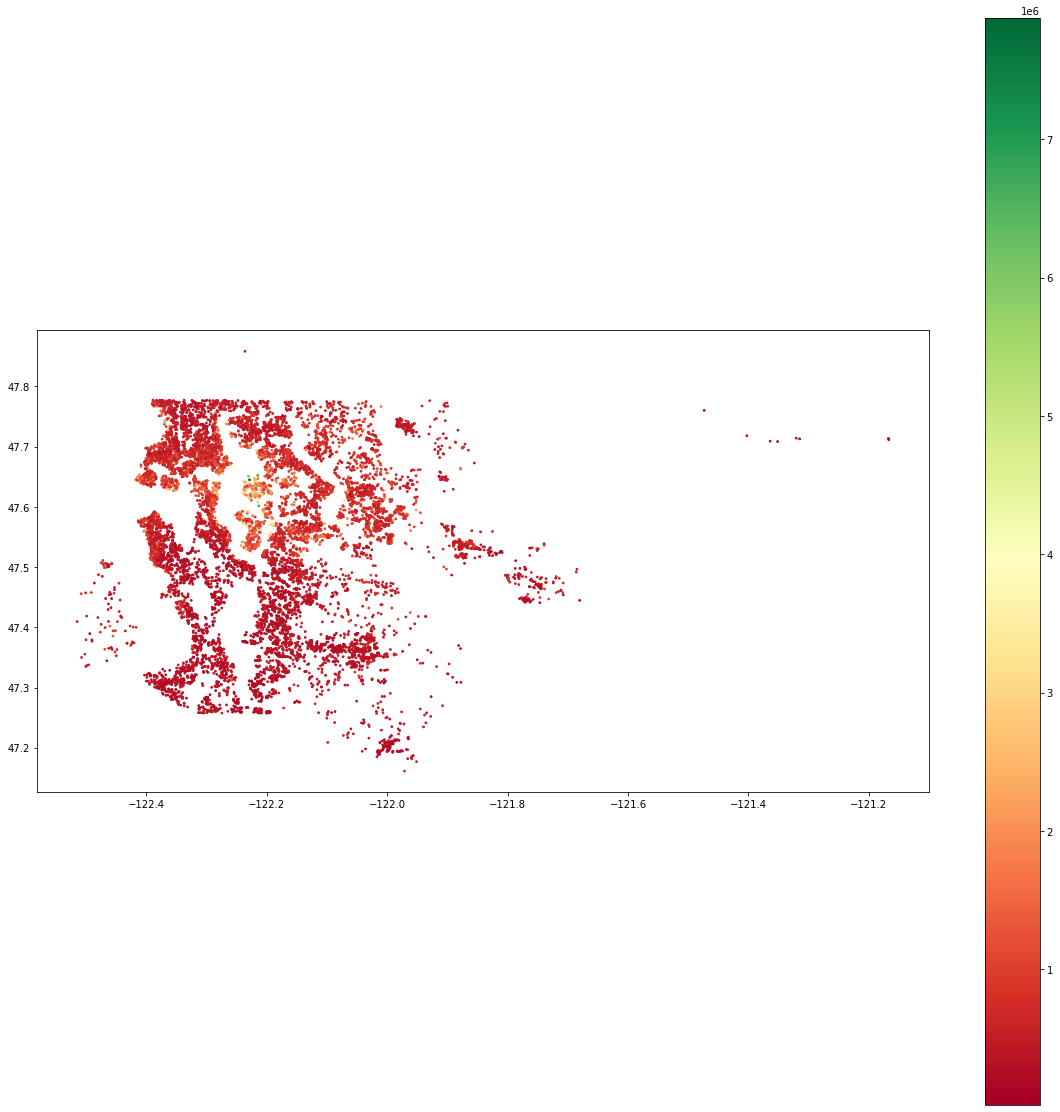

In [21]:
#data.plot.scatter('Longitude','Latitude',c='SaleDollarCnt',colormap='RdYlGn',figsize=(10,10),s=1)
gdf.plot("SaleDollarCnt", legend=True, colormap='RdYlGn',s=3, figsize=(20,20))

As we can see, there is a small place in downtoan where properties are particularly expensive. This graph also shows the importance of including a measure for distance from central business district as well as location information in general.

Now let's examine importance of each variable in price determination using scatterplots:

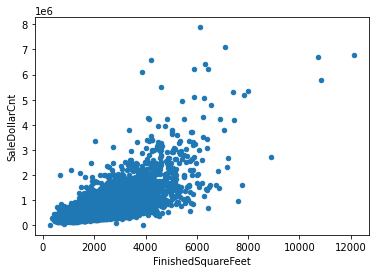

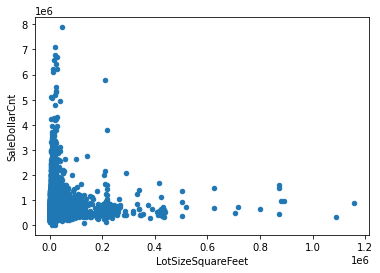

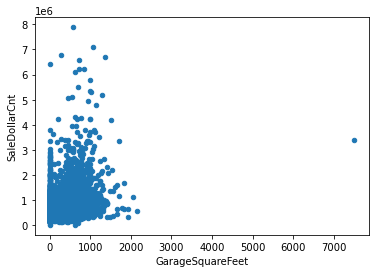

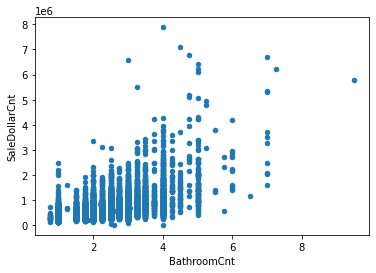

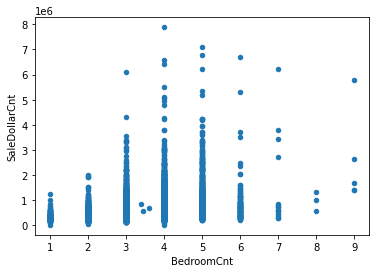

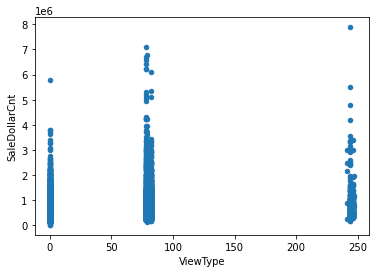

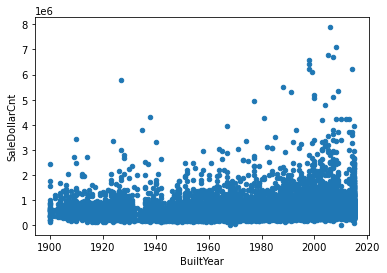

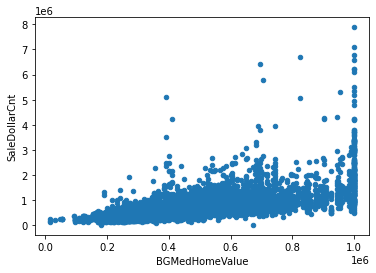

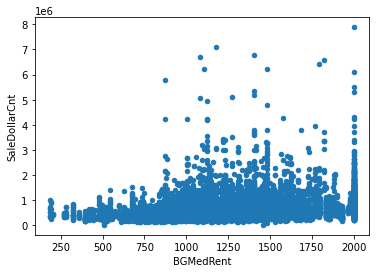

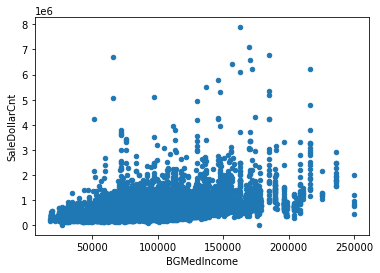

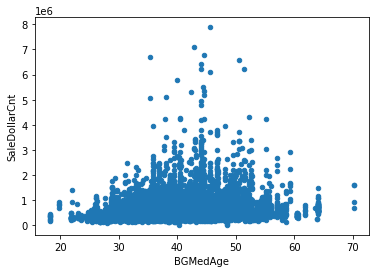

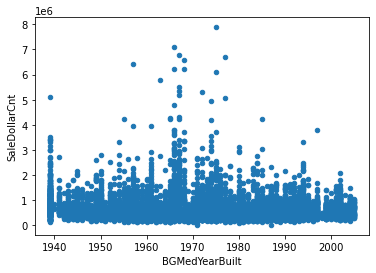

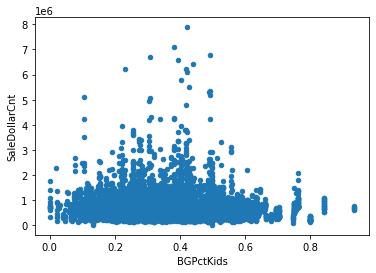

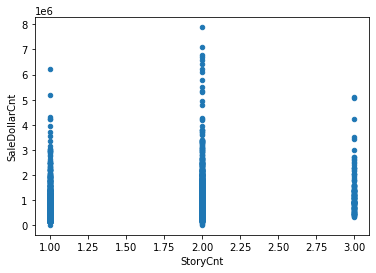

In [22]:
df = data
ax1 = df.plot.scatter(x='FinishedSquareFeet', y='SaleDollarCnt')
ax2 = df.plot.scatter(x='LotSizeSquareFeet', y='SaleDollarCnt')
ax3 = df.plot.scatter(x='GarageSquareFeet', y='SaleDollarCnt')
ax4 = df.plot.scatter(x='BathroomCnt', y='SaleDollarCnt')
ax5 = df.plot.scatter(x='BedroomCnt', y='SaleDollarCnt')
ax6 = df.plot.scatter(x='ViewType', y='SaleDollarCnt')
ax7 = df.plot.scatter(x='BuiltYear', y='SaleDollarCnt')
ax8 = df.plot.scatter(x='BGMedHomeValue', y='SaleDollarCnt')
ax9 = df.plot.scatter(x='BGMedRent', y='SaleDollarCnt')
ax10 = df.plot.scatter(x='BGMedIncome', y='SaleDollarCnt')
ax11 = df.plot.scatter(x='BGMedAge', y='SaleDollarCnt')
ax12 = df.plot.scatter(x='BGMedYearBuilt', y='SaleDollarCnt')
ax13 = df.plot.scatter(x='BGPctKids', y='SaleDollarCnt')
ax14 = df.plot.scatter(x='StoryCnt', y='SaleDollarCnt')

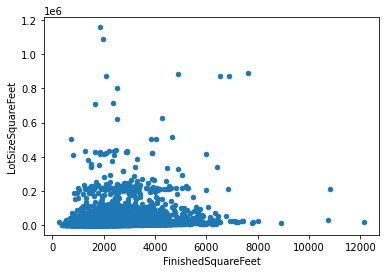

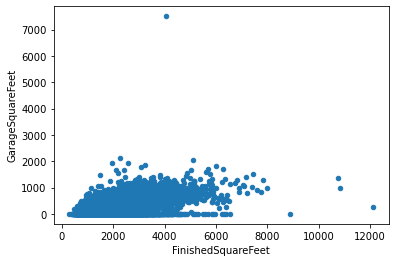

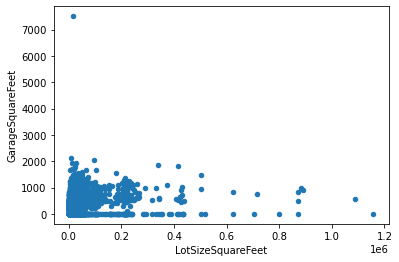

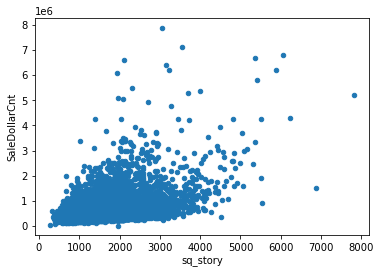

In [23]:
ax2_1 = df.plot.scatter(x='FinishedSquareFeet', y='LotSizeSquareFeet')
ax2_2 = df.plot.scatter(x='FinishedSquareFeet', y='GarageSquareFeet')
ax2_3 = df.plot.scatter(x='LotSizeSquareFeet', y='GarageSquareFeet')
df['sq_story'] = df['FinishedSquareFeet']/data['StoryCnt'].astype(int)
ax2_4 = df.plot.scatter(x='sq_story', y='SaleDollarCnt')



I include all of these features that have a correlation with labels. I also add some other features that are important theoretically:

1-Relationship between price and square footage seems to be nonlinear. I add higher order terms of quadratic footage to capture that.

2-Distance from the central business district is a factor that is theoretically shown to be one of the main drivers of price. I manually create that variable and add its higher order terms as well. I assume the CBD is where I observe the highest concentration of expensive houses. I choose this point crudely and set it at (47.64,-122.22). This can be done more rigorously but for my purpose this is sufficient.

3- To Further capture location effects, I also add a Tract fixed effect (set of one hot encoded dummies). This captures the effect of llocating on different neighborhoods which is one of the main drivers of price.

4-I add other public block group information like crime rate, graduation rate, and poverty rate.


In [24]:
#some correction for view_types:
data.loc[data.ViewType == 247, 'ViewType'] = 246

#categorical variables
df = data
df['Tract'] = (np.floor(df['BlockGroup']/10)).astype(int)
df = pd.get_dummies(df, columns=["ViewType","StoryCnt","Tract"])

In [25]:
df['Fsqf2'] = df['FinishedSquareFeet']**2
df['Lsqf2'] = df['LotSizeSquareFeet']**2
df['Gsqf2'] = df['GarageSquareFeet']**2
df['lat2'] = df['map_Latitude']**2
df['lon2'] = df['map_Longitude']**2
df['log_price'] = np.log(df['SaleDollarCnt'])
df['sq_story'] = df['FinishedSquareFeet']/data['StoryCnt'].astype(int)
df['dCBD'] = np.sqrt((df['map_Latitude']-47.64)**2 + (df['map_Longitude']+122.22)**2)
df['dCBD2'] = df['dCBD']**2

y = df['SaleDollarCnt']
y_log = df['log_price']
colnames = ['ADRKE001','ADRWE001'
        ,'BGMedHomeValue','BGMedYearBuilt','BGMedRent'
        ,'BGMedIncome','BGPctKids','BGMedAge','BGPctOwn','BGPctVacant'       
        ,'ADNEE002','ADNEE003','ADNEE004','ADNEE005','ADNEE006','ADNEE007','ADNEE008'
        ,'sq_story','Gsqf2','Fsqf2','Lsqf2'
        ,'map_Latitude','map_Longitude','lat2','lon2'
        ,'GraduationRate','crime_count','dCBD','dCBD2','r_C000','w_C000'
        ,'BedroomCnt','BathroomCnt'
        ,'TransMonth'
        ,'FinishedSquareFeet','GarageSquareFeet','LotSizeSquareFeet','BuiltYear'
        ,'ViewType_0','ViewType_241','ViewType_244','ViewType_246'
        ,'ViewType_78','ViewType_79','ViewType_82'
        ,'StoryCnt_1','StoryCnt_2','StoryCnt_3']
fenames = [col for col in df if col.startswith('Tract')]
X = df[colnames+fenames]

# Train and Test the Prediction Model

First, I divide the data I have into training (80%) and validation (20%) 

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

Just to start off, I model the data using a simple linear regression model to see how it performs:

In [27]:
#log linear regression
lin_reg_log = LinearRegression(normalize=False)
lin_reg_log.fit(X_train,y_train)

y_pred = np.exp(lin_reg_log.predict(X_test))
y_test_e = np.exp(y_test)
AAPError(y_test_e, y_pred)

11.817314812977601

Now let's try a random forest model:

In [28]:
#log random forest
randomforest_log = RandomForestRegressor(n_estimators=10,max_features=7)
randomforest_log.fit(X_train,y_train)

y_pred = np.exp(randomforest_log.predict(X_test))
y_test_e = np.exp(y_test)
AAPError(y_test_e, y_pred)

13.917290458486123

To get a sense of each variables contribution to the regression, here I plot the importance of each variable:

Text(0, 0.5, 'Mean decrease in impurity')

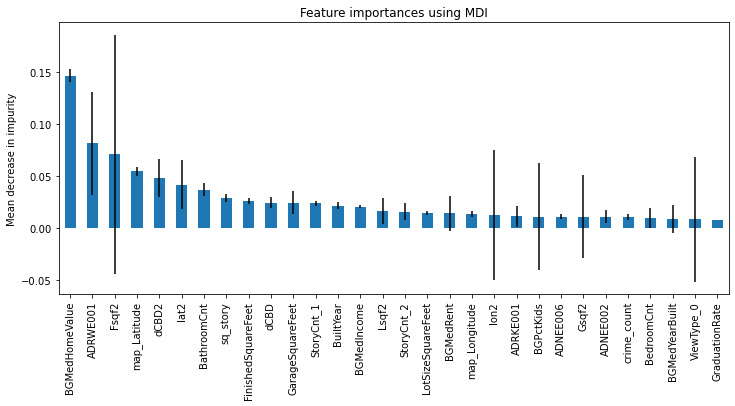

In [29]:
importances = randomforest_log.feature_importances_
std = np.std([tree.feature_importances_ for tree in randomforest_log.estimators_], axis=0)

feature_names = X_train.columns.values.tolist()
forest_importances = pd.Series(
    importances, index=feature_names).sort_values(ascending=False)
fig, ax = plt.subplots()
forest_importances[:30].plot.bar(yerr=std[:30], ax=ax, figsize=(12,5))
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

And now the gradient boosting algorithm:

In [30]:
#Gradient Boosting regression
gboost = GradientBoostingRegressor()
gboost.fit(X_train,y_train)

y_pred = np.exp(gboost.predict(X_test))
y_test_e = np.exp(y_test)
AAPError(y_test_e, y_pred)

12.380217062676383

An important flaw in my model is that since I use ScikitLearn package, I can't really change the optimization loss function. So I am not really optimizing on the same metric that the project will be evaluated on. This is something that having more time would solve since I could use other more time consuming and customizable packages like Tensorflow or Pytorch. Here, minimizing MSE which is the default sklearn error means that I get larger error on cheap houses. To see how error is distributed:

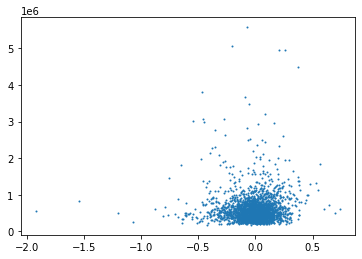

In [31]:
plt.scatter((y_test_e-y_pred)/y_test_e, y_pred,s=1)

I also try stacking all of the previous models to see if that gives a better result:

In [32]:
estimators = [('lr', LinearRegression()),
             ('gb', GradientBoostingRegressor()),
             ('rf',RandomForestRegressor(n_estimators=100,random_state=42))]

reg = StackingRegressor(estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                        random_state=42))

reg.fit(X_train, y_train)

y_pred = np.exp(reg.predict(X_test))
y_test_e = np.exp(y_test)
AAPError(y_test_e, y_pred)


12.678760025169518

As we can see, the simple linear regression gives the best result among all models. I choose this as the final model and greate estimations using linear regression on the test data:

In [35]:
test_data = pd.read_csv(os.getcwd()+'/Data Science ZExercise_TEST_CONFIDENTIAL2.csv')
#feature transformation
test_data['StoryCnt'] = np.floor(test_data['StoryCnt']).astype(int).astype(str)
test_data['BuiltYear'] = np.ceil(test_data['BuiltYear'])
test_data['ViewType'].fillna(0, inplace=True)
test_data['ViewType'] = test_data['ViewType'].astype(int).astype(str)
test_data['GarageSquareFeet'].fillna(0, inplace=True)
test_data['TransMonth'] = pd.DatetimeIndex(test_data['TransDate']).month

test_data['map_Latitude'] = test_data['Latitude']/1000000
test_data['map_Longitude'] = test_data['Longitude']/1000000
#geolocate blocks
flag = 1
if flag==0:
    test_data['Block']=np.nan
    for i in test_data.index:
        test_data.at[i,'Block'] = geolocate(test_data.loc[i,'map_Latitude'],test_data.loc[i,'map_Longitude'])

    test_data['BlockGroup'] = np.floor(test_data['Block']/1000).astype(int)
    test_data.to_csv(os.getcwd()+'/test_data_BG_added.csv')

In [36]:
test_data = pd.read_csv(os.getcwd()+'/test_data_BG_added.csv')
crime_data = pd.read_csv(os.getcwd()+'/crime_BG.csv')
test_data = pd.merge(test_data, crime_data, how="left", on=["BlockGroup"])
test_data['crime_count'] = test_data['crime_count'].fillna(0)
rac = pd.read_csv(os.getcwd()+'/wa_rac_S000_JT00_2015.csv')[['BlockGroup','r_C000']]
wac = pd.read_csv(os.getcwd()+'/wa_wac_S000_JT00_2015.csv')[['BlockGroup','w_C000']]
test_data = pd.merge(test_data, rac, how="left", on=["BlockGroup"])
test_data['r_C000'] = test_data['r_C000'].fillna(0)
test_data = pd.merge(test_data, wac, how="left", on=["BlockGroup"])
test_data['w_C000'] = test_data['w_C000'].fillna(0)
school = pd.read_csv(os.getcwd()+'/school.csv')
school = school[['BlockGroup','GraduationRate']]
test_data = pd.merge(test_data, school, how="left", on=["BlockGroup"])
test_data['GraduationRate'] = test_data['GraduationRate'].fillna(0)
census = pd.read_csv(os.getcwd()+'/census.csv')
test_data = pd.merge(test_data, census, how="left", on=["BlockGroup"])

In [37]:
radians = np.radians(test_data[["map_Latitude", "map_Longitude"]].values)
tree = BallTree(radians, leaf_size=15, metric='haversine')
for distance_in_km in [0.01,0.1,1,10]:
    radius = distance_in_km / 6378
    is_within, distances = tree.query_radius(
        radians, r=radius, count_only=False, return_distance=True)    
    for variable in ['BGMedRent','BGMedHomeValue','BGMedYearBuilt','ADRKE001','ADRWE001']: 
        test_data['temp'] = np.array(
            [ np.nanmedian( test_data[variable].values[withins] ) for withins in is_within ])
        test_data[variable].fillna(test_data['temp'], inplace=True) 

In [38]:
test_df=test_data
test_df['Tract'] = (np.floor(test_df['BlockGroup']/10)).astype(int)
test_df = pd.get_dummies(test_df, columns=["ViewType","StoryCnt","Tract"])
test_df['Fsqf2'] = test_df['FinishedSquareFeet']**2
test_df['Lsqf2'] = test_df['LotSizeSquareFeet']**2
test_df['Gsqf2'] = test_df['GarageSquareFeet']**2
test_df['lat2'] = test_df['map_Latitude']**2
test_df['lon2'] = test_df['map_Longitude']**2
test_df['log_price'] = np.log(test_df['SaleDollarCnt'])
test_df['sq_story'] = test_df['FinishedSquareFeet']/test_data['StoryCnt'].astype(int)
test_df['dCBD'] = np.sqrt((test_df['map_Latitude']-47.64)**2 
                          + (test_df['map_Longitude']+122.22)**2)
test_df['dCBD2'] = test_df['dCBD']**2

colnames = ['ADRKE001','ADRWE001'
        ,'BGMedHomeValue','BGMedYearBuilt','BGMedRent'
        ,'BGMedIncome','BGPctKids','BGMedAge','BGPctOwn','BGPctVacant'       
        ,'ADNEE002','ADNEE003','ADNEE004','ADNEE005','ADNEE006','ADNEE007','ADNEE008'
        ,'sq_story','Gsqf2','Fsqf2','Lsqf2'
        ,'map_Latitude','map_Longitude','lat2','lon2'
        ,'GraduationRate','crime_count','dCBD','dCBD2','r_C000','w_C000'
        ,'BedroomCnt','BathroomCnt'
        ,'TransMonth'
        ,'FinishedSquareFeet','GarageSquareFeet','LotSizeSquareFeet','BuiltYear'
        ,'ViewType_0','ViewType_78','ViewType_79','ViewType_82'
        ,'ViewType_241','ViewType_244','ViewType_246'
        ,'StoryCnt_1','StoryCnt_2','StoryCnt_3']
fenames = [col for col in test_df if col.startswith('Tract')]
X_test_final = test_df[colnames+fenames]


In [50]:
#retrain model with all of the training data
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.1, random_state=42)
lin_reg_log = LinearRegression(normalize=False)
lin_reg_log.fit(X_train,y_train)

#get predictions on the test data
output = test_df
output['SaleDollarCnt'] = np.exp(lin_reg_log.predict(X_test_final))
output[['PropertyID','SaleDollarCnt']].set_index('PropertyID').to_csv((os.getcwd()+'/final_output.csv'))